# OncoKB driver annotations study

Created: **23/07/18**  
Last modified: **03/08/18**

**Goal:** ...  
This notebook is divided in ? parts:

* **1. Bla**: Bla
***

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#oncogenic" data-toc-modified-id="oncogenic-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>oncogenic</code></a></span></li><li><span><a href="#Alternative-amino-acid" data-toc-modified-id="Alternative-amino-acid-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Alternative amino-acid</a></span></li><li><span><a href="#High-cosmic_count" data-toc-modified-id="High-cosmic_count-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>High <code>cosmic_count</code></a></span></li></ul></div>

In [29]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [30]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE, oncokb = TRUE, gene_type = TRUE)

## `oncogenic`


            Unknown    Likely Oncogenic           Oncogenic Predicted Oncogenic 
             180969               47373               16230                2874 
       Inconclusive      Likely Neutral 
                524                 380 

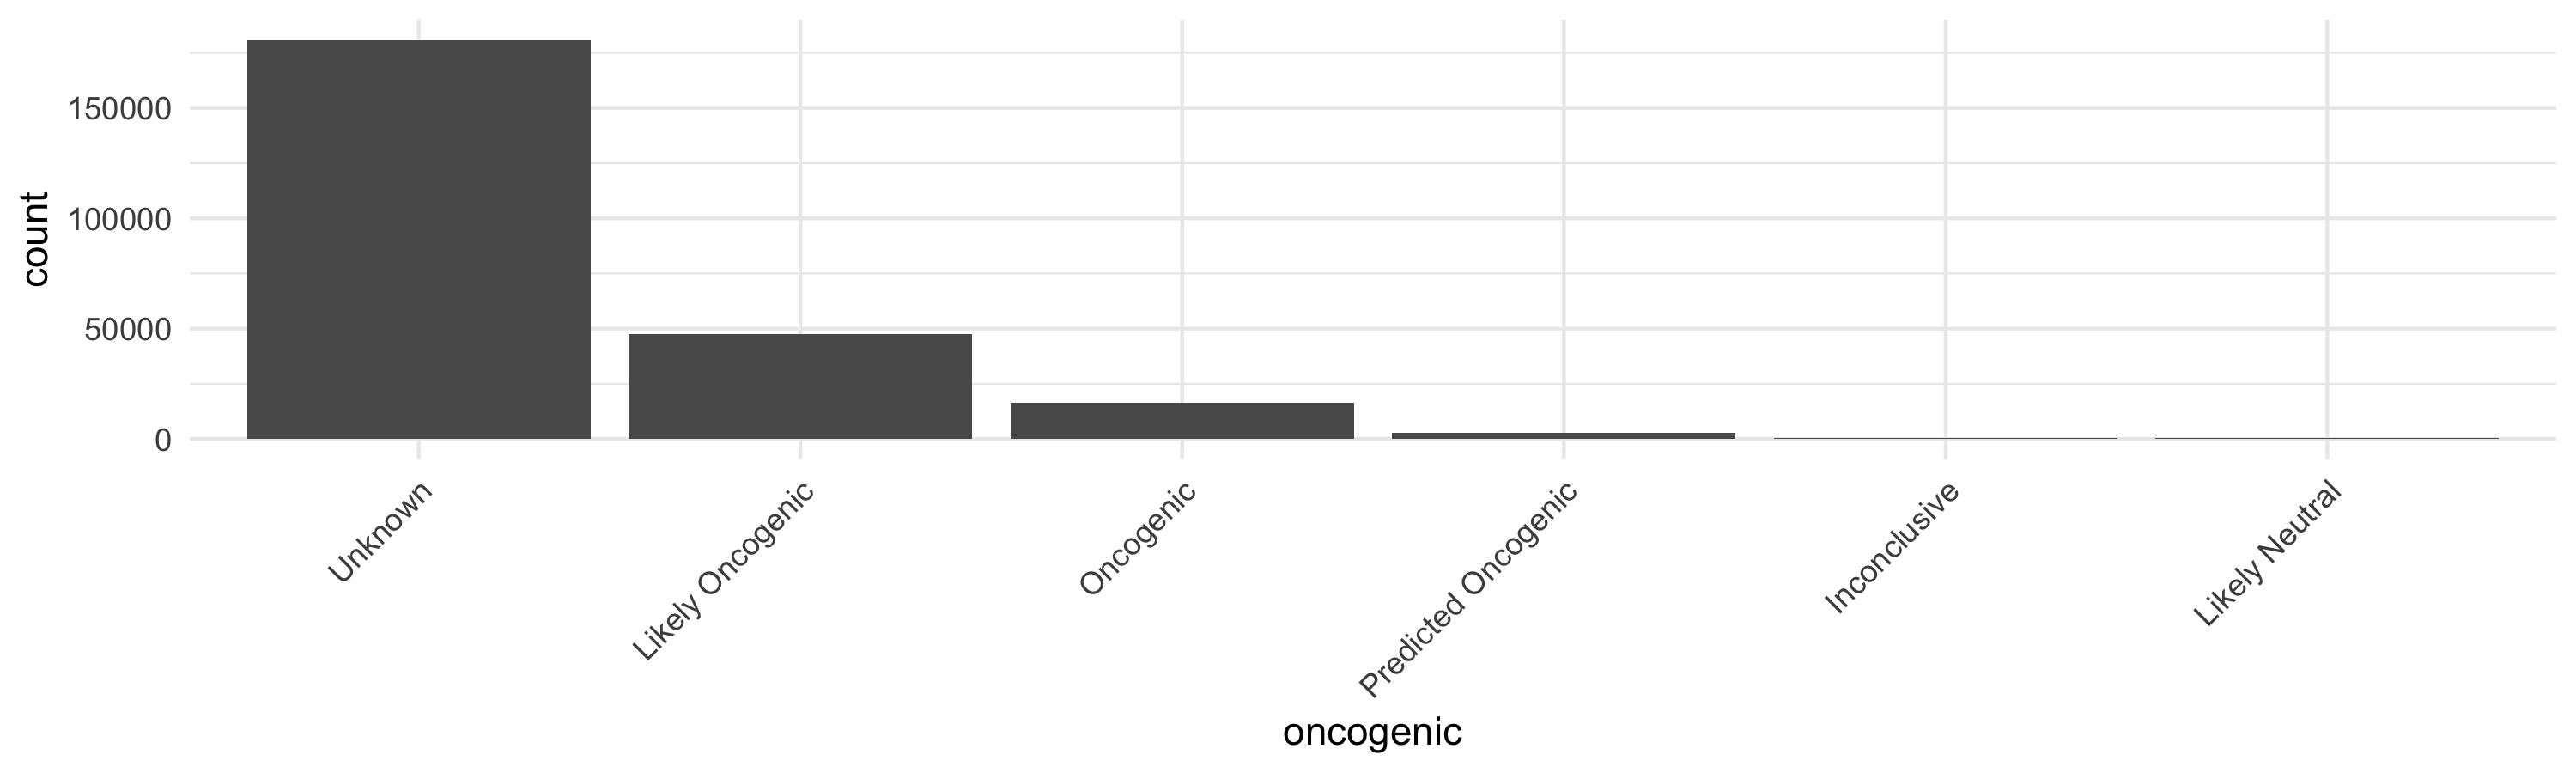

In [31]:
impact <- sort_histogram(impact, "oncogenic")
rev(sort(table(impact$oncogenic)))
notebook_plot_size(10, 3)
ggplot(impact) + geom_bar(aes(oncogenic)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

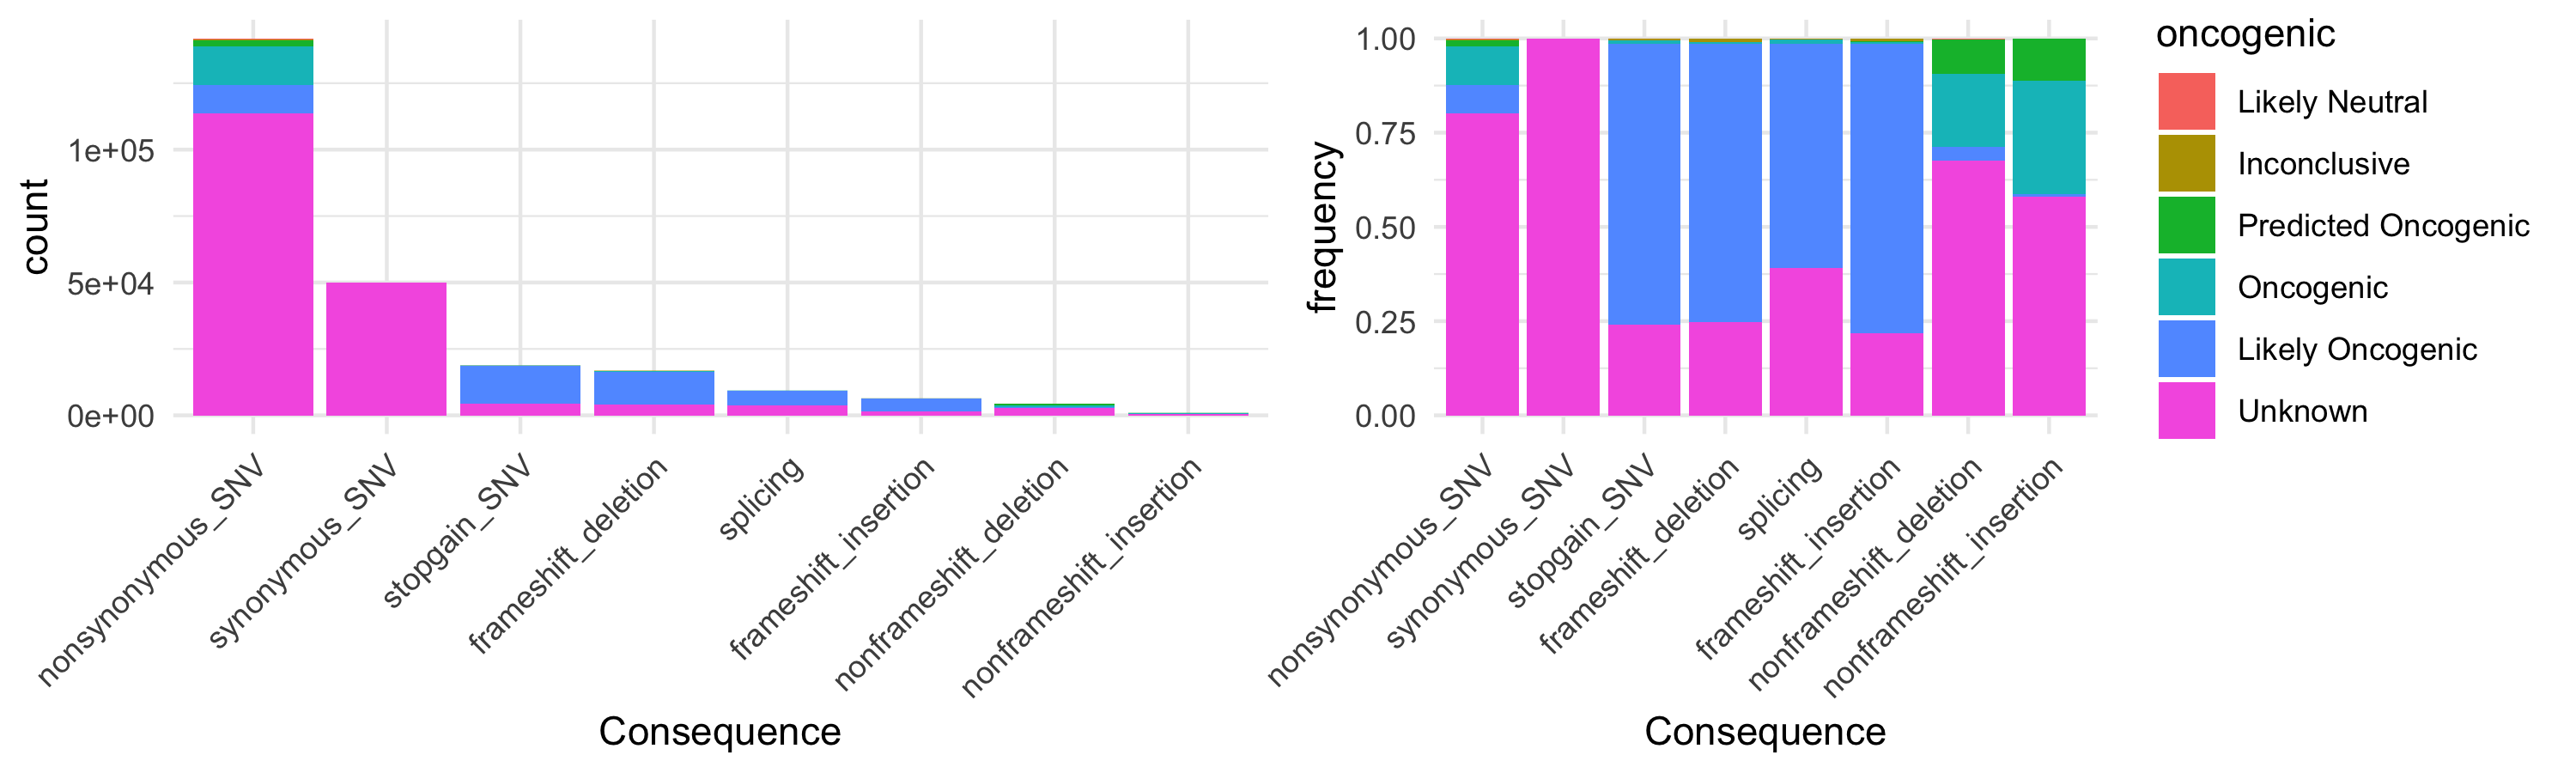

In [32]:
plot_contingency_table_as_histograms(impact, "Consequence", "oncogenic")

Non of the synonymous mutations are in OncoKB, and among the truncating mutations a lot are predicted as `Likely Oncogenic`.

In [33]:
impact$class <- "unknown"
impact$class[impact$confidence_class == "OK_NOT_SO" | impact$confidence_class == "UNLIKELY" ] <- "non-somatic"
impact$class[impact$confidence_class == "AUTO_OK"   | impact$confidence_class == "MANUAL_OK"] <- "somatic"

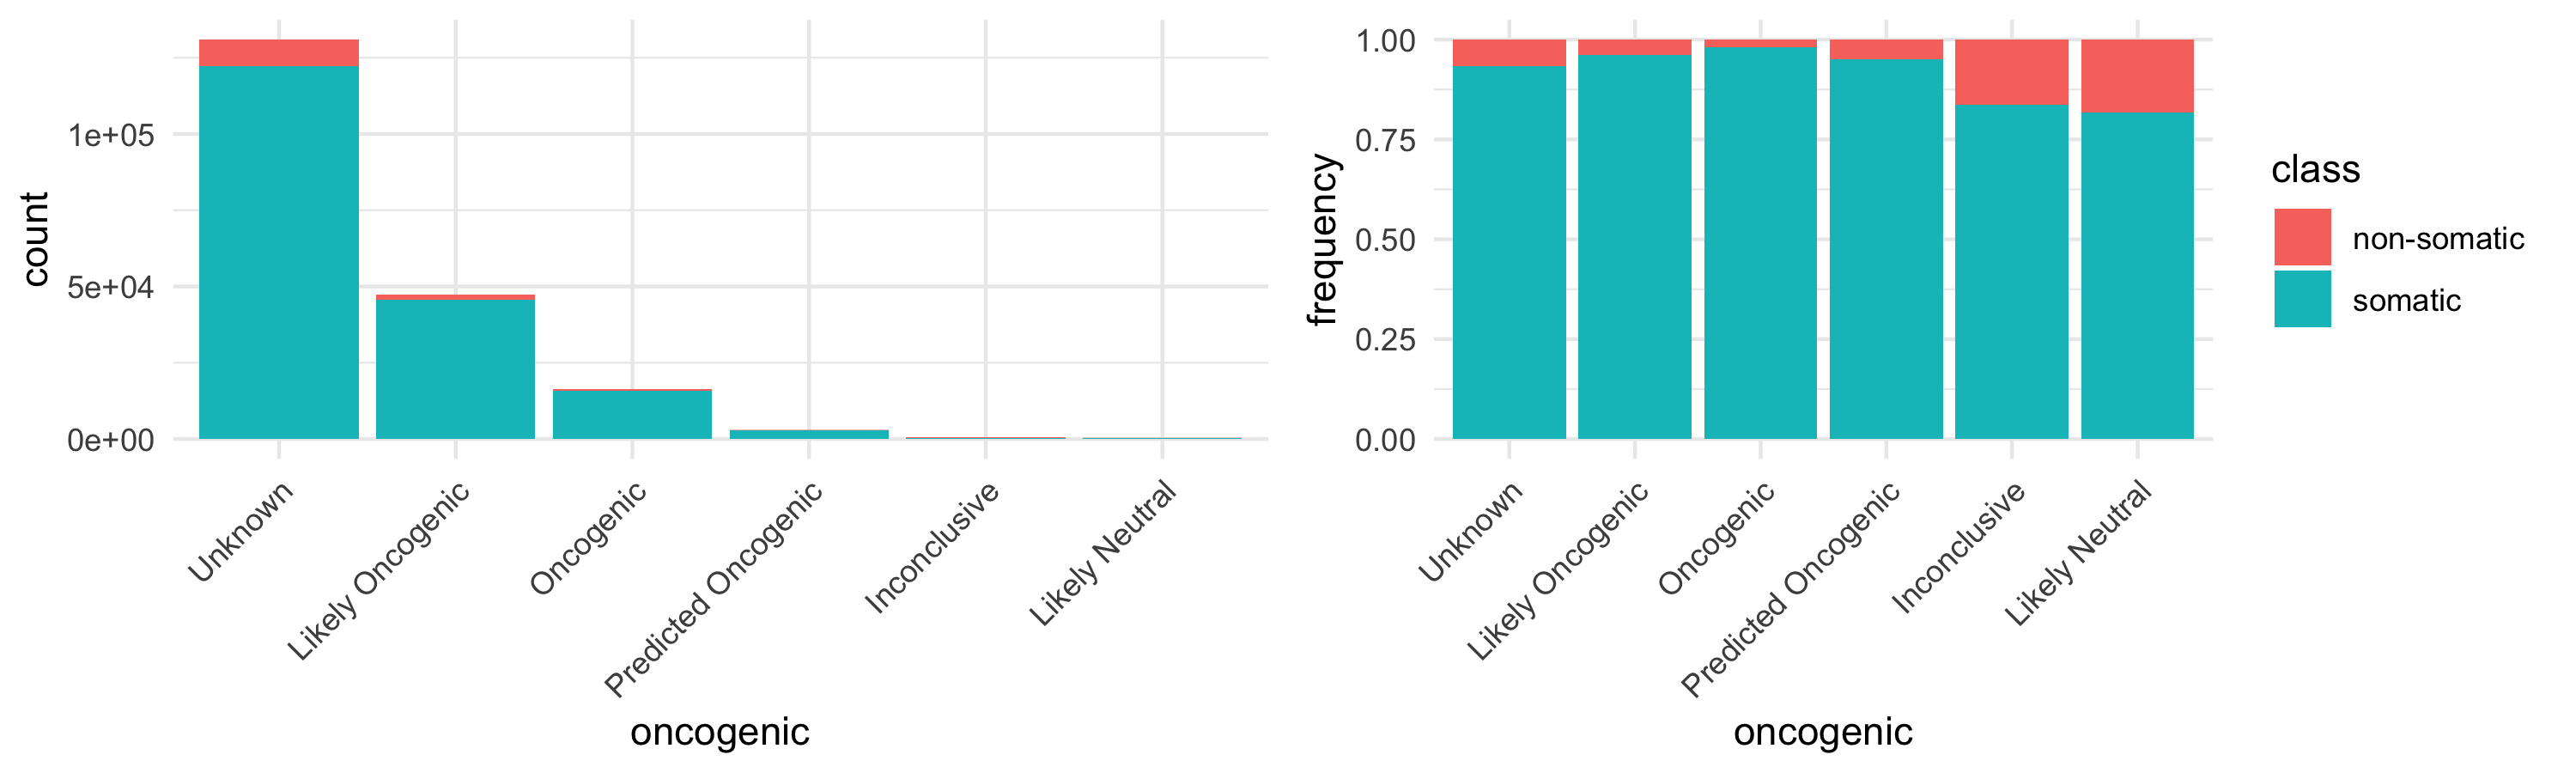

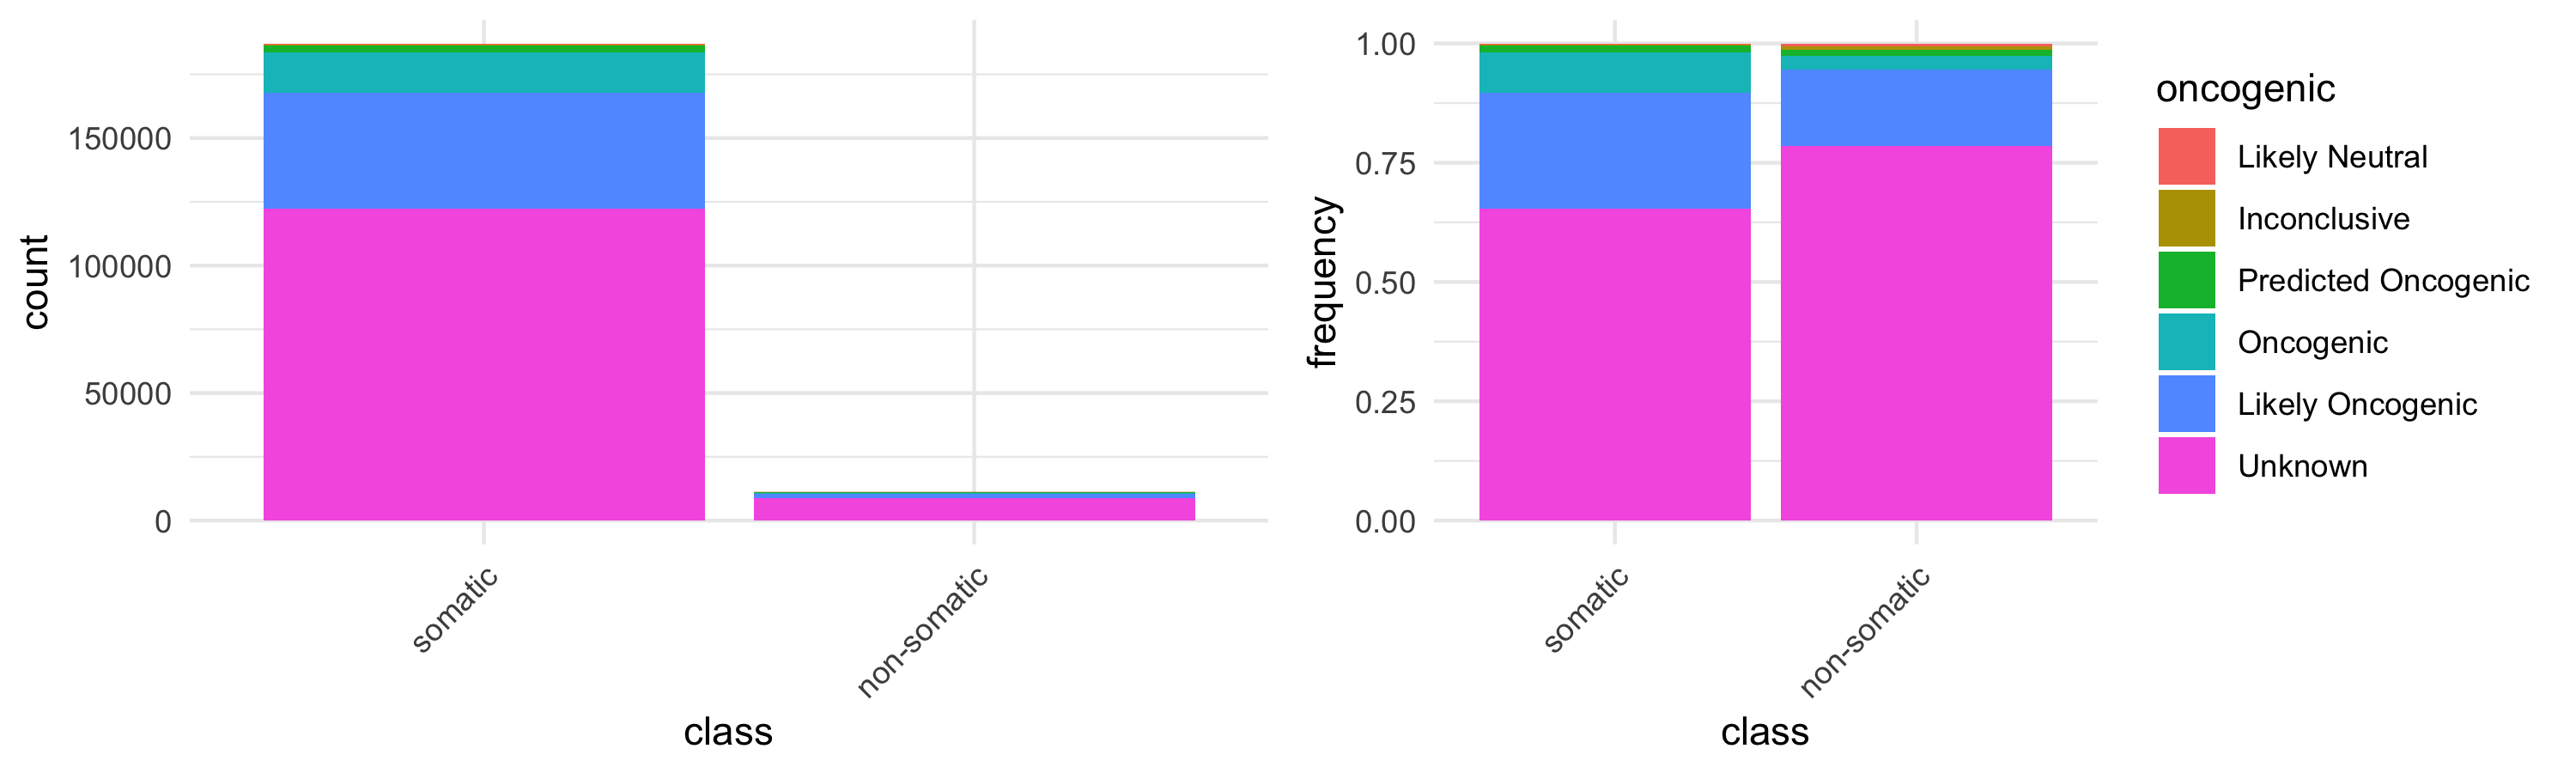

In [34]:
plot_contingency_table_as_histograms(impact[impact$class != "unknown",], "oncogenic", "class")
plot_contingency_table_as_histograms(impact[impact$class != "unknown",], "class", "oncogenic")

In [35]:
drivers <- impact[impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic"),]
nrow(drivers)

[1] 63603

[1] 243

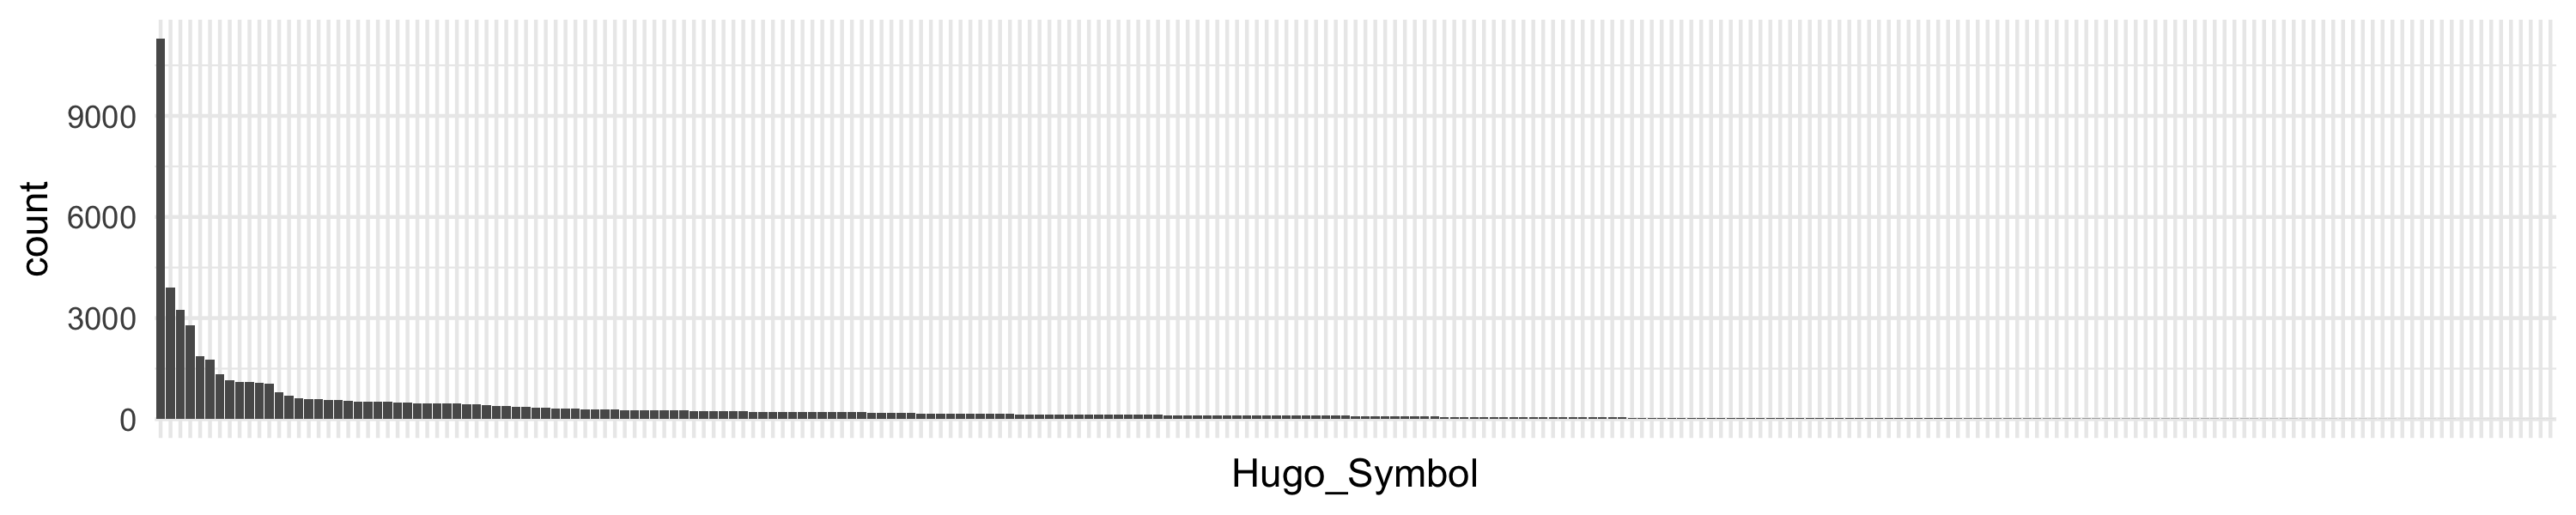

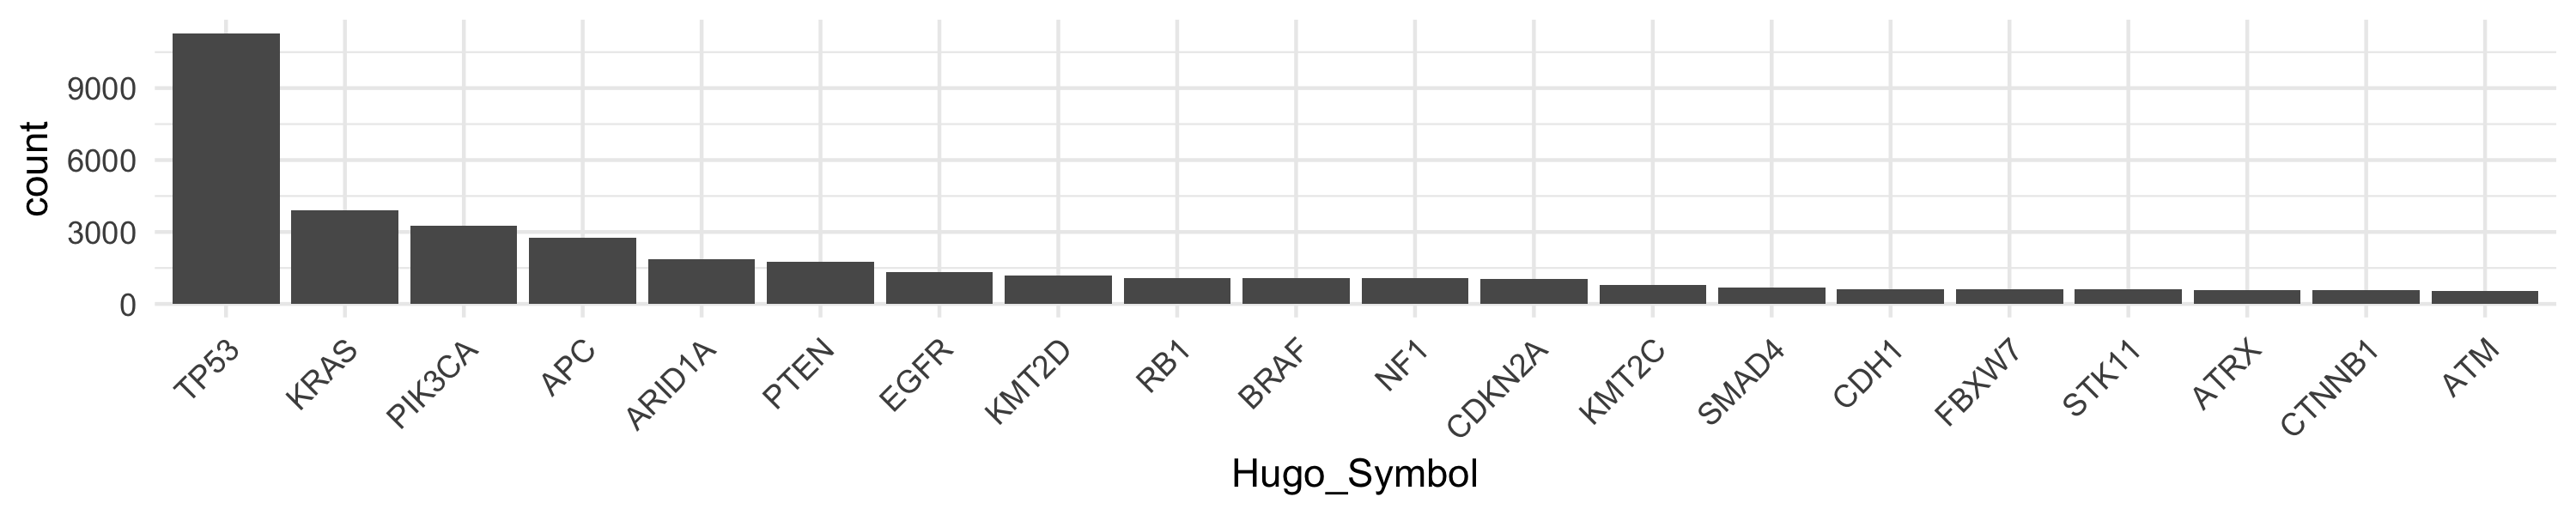

In [36]:
length(unique(drivers$Hugo_Symbol))
drivers <- sort_histogram(drivers, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(drivers) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(drivers, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Alternative amino-acid

We will only work on the coding mutations:

In [42]:
impact <- impact[impact$Consequence != "synonymous_SNV",]

In [38]:
addmargins(rev(sort(table(impact$oncogenic))))


            Unknown    Likely Oncogenic           Oncogenic Predicted Oncogenic 
             130959               47373               16230                2874 
       Inconclusive      Likely Neutral                 Sum 
                524                 380              198340 

In [43]:
oncokb <- read.table("../../../data/oncokb/allAnnotatedVariants.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE)

ERROR: Error in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, : line 3790 did not have 10 elements


In [13]:
oncokb <- read.table("../../../oncokb/allAnnotatedVariants,txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
oncokb$key <- paste0(oncokb$Gene, '.p.',oncokb$Alteration)

# create the impact `oncokb_key`
impact$oncokb_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)

impact$oncokb_key[impact$Consequence == "splicing" | impact$HGVSp_Short == ''] <- 'other'
is_truncating <- which(impact$Consequence %in% c("frameshift_deletion", "frameshift_insertion",
                                                 "stopgain_SNV", "splicing"))
impact$oncokb_key[is_truncating] <- paste0(impact$Hugo_Symbol[is_truncating], '.p.Truncating Mutations')

In [14]:
length(impact$oncokb_key[impact$oncogenicity == "not_in_oncokb"])
head(impact$oncokb_key)

[1] 131956

[1] "TP53.p.T256P"                 "PIK3R3.p.I298M"              
[3] "ATR.p.R2431M"                 "PDGFRA.p.L465M"              
[5] "FBXW7.p.Truncating Mutations" "FBXW7.p.Truncating Mutations"

In [15]:
get_alternative_keys_in_oncokb <- function(key) {
    amino_acid_list = c('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                        'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')
    
    if (grepl("Truncating Mutations", key)) {
        return ('')
    }
    
    else {
        amino_acid_list <- amino_acid_list[amino_acid_list != substr(key, nchar(key), nchar(key))]
        alt_keys <- paste0(substr(key, 1, nchar(key)-1), amino_acid_list)
        in_oncokb <- which(alt_keys %in% oncokb$key)
        
        if (sum(in_oncokb))
            return (c(key, alt_keys[in_oncokb]))
        else
            return ('')
    }
}

get_alternative_keys_in_oncokb("MAP2K4.p.R154A")
get_alternative_keys_in_oncokb("TP53.p.T256P")
get_alternative_keys_in_oncokb('FBXW7.p.Truncating Mutations')

[1] "MAP2K4.p.R154A" "MAP2K4.p.R154W"

[1] ""

[1] ""

In [3]:
impact_not_in_oncokb <- impact[impact$oncogenicity == "not_in_oncokb",]

In [11]:
dd <- sapply(unique(impact_not_in_oncokb$oncokb_key), get_alternative_keys_in_oncokb)
dd <- unique(dd[dd != ''])

ERROR: Error in match.fun(FUN): object 'get_alternative_keys_in_oncokb' not found


In [17]:
sprintf("%.2f%% (%d) of the impact oncokb_keys are concerned",
        length(dd) / length(unique(impact$oncokb_key)) * 100,
        length(dd))
head(dd)

[1] "1.36% (1335) of the impact oncokb_keys are concerned"

[[1]]
[1] "PTEN.p.L23V" "PTEN.p.L23F"

[[2]]
[1] "TP53.p.I255T" "TP53.p.I255F"

[[3]]
[1] "GNAS.p.Q227K" "GNAS.p.Q227R" "GNAS.p.Q227L"

[[4]]
[1] "SMAD4.p.D537V" "SMAD4.p.D537E" "SMAD4.p.D537Y"

[[5]]
[1] "FGFR4.p.V550L" "FGFR4.p.V550E"

[[6]]
[1] "TSC1.p.L191I" "TSC1.p.L191H"

In [18]:
table( sapply(dd, function(d) length(unique(d))-1) ) # number of viable replacements


  1   2   3   4   5   6   7 
918 229 120  46  19   1   2 

## High `cosmic_count`

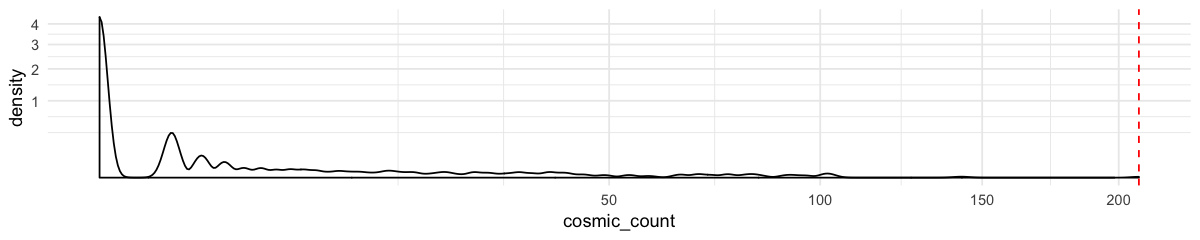

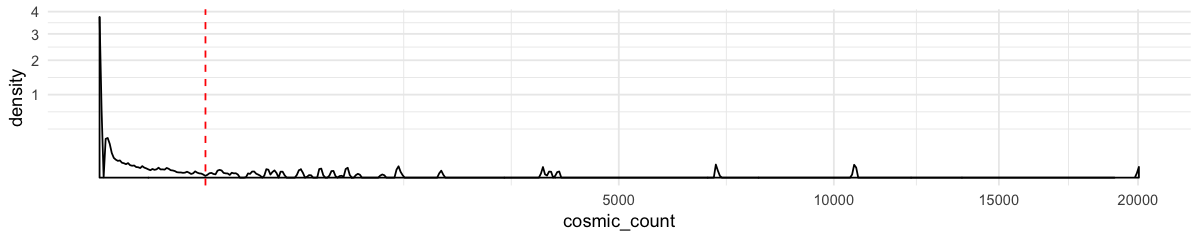

In [7]:
notebook_plot_size(10, 2)
ggplot(impact_not_in_oncokb) + geom_density(aes(cosmic_count)) + scale_x_sqrt() + scale_y_sqrt() +
        geom_vline(aes(xintercept = max(impact_not_in_oncokb)), linetype = "dashed", color = "red")
ggplot(impact) + geom_density(aes(cosmic_count)) + scale_x_sqrt() + scale_y_sqrt() +
        geom_vline(aes(xintercept = max(impact_not_in_oncokb)), linetype = "dashed", color = "red")